# Animated Correlation Network Filtering - Examples

This notebook demonstrates the complete pipeline for creating animated filtered correlation networks.

Based on the geometric filtering methods of Tomaso Aste and colleagues.

## 🎉 NEW Feature: Dynamic Force-Directed Layout!

This notebook now includes demonstrations of **dynamic layouts** where nodes move according to the evolving correlation structure, making animations more intuitive and engaging!

### What You'll Learn:
1. Generate synthetic correlation data
2. Apply network filtering (MST, PMFG, TMFG)
3. Create **dynamic** animations (nodes move with correlations) ✨ NEW!
4. Create **static** animations (nodes stay fixed)
5. Compare different smoothing parameters
6. Analyze network metrics over time

In [4]:
import sys
sys.path.append("../src") 

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from correlation_network_animation import (
    SyntheticCorrelationGenerator,
    RollingCorrelationEstimator,
    CorrelationFilter,
    NetworkAnimator
)

%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 8)

## 1. Generate Synthetic Data with Time-Varying Correlations

In [6]:
# Parameters
n_assets = 20
total_days = 500
window_size = 100

print(f"Generating synthetic data...")
print(f"  Assets: {n_assets}")
print(f"  Days: {total_days}")
print(f"  Window: {window_size}")

# Generate data
generator = SyntheticCorrelationGenerator(n_assets=n_assets, seed=42)
returns_df, true_correlations = generator.generate_time_series(
    total_days=total_days,
    window_size=window_size,
    volatility_process=0.05
)

print(f"\nGenerated returns shape: {returns_df.shape}")
print(f"Date range: {returns_df.index[0]} to {returns_df.index[-1]}")

Generating synthetic data...
  Assets: 20
  Days: 500
  Window: 100

Generated returns shape: (500, 20)
Date range: 2020-01-01 00:00:00 to 2021-05-14 00:00:00


### Visualize Synthetic Returns

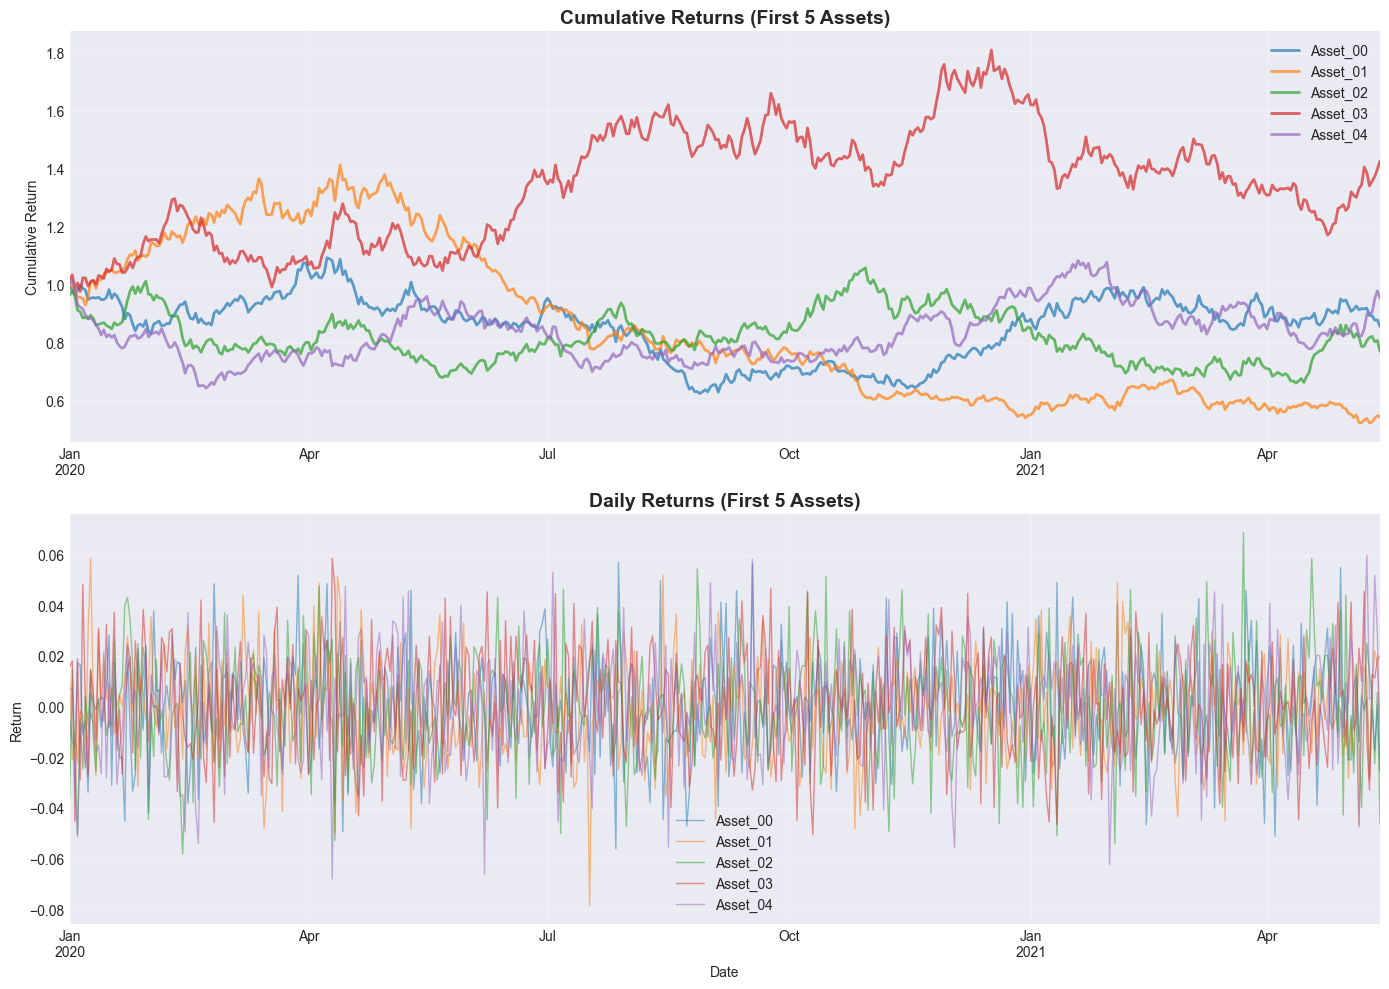

In [7]:
# Plot cumulative returns for first 5 assets
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Cumulative returns
cumulative_returns = (1 + returns_df).cumprod()
cumulative_returns.iloc[:, :5].plot(ax=axes[0], alpha=0.7, linewidth=2)
axes[0].set_title('Cumulative Returns (First 5 Assets)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Cumulative Return')
axes[0].legend(loc='best')
axes[0].grid(True, alpha=0.3)

# Daily returns
returns_df.iloc[:, :5].plot(ax=axes[1], alpha=0.5, linewidth=1)
axes[1].set_title('Daily Returns (First 5 Assets)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Return')
axes[1].legend(loc='best')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Visualize True Correlation Evolution

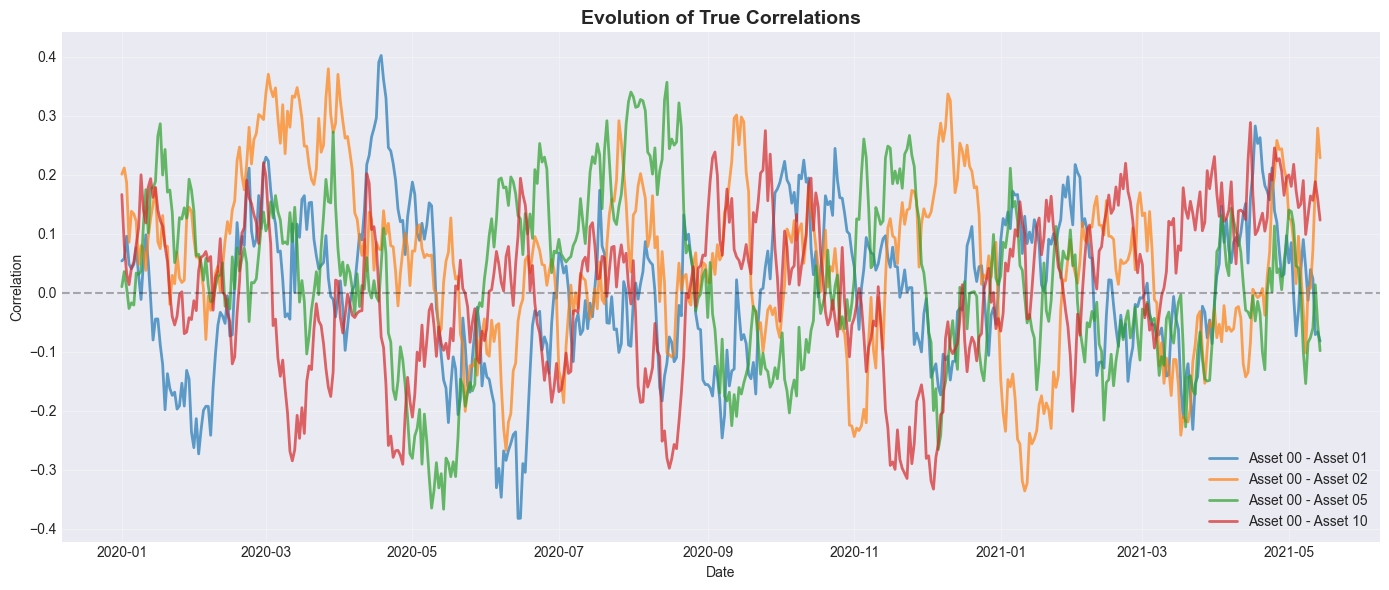

In [8]:
# Plot evolution of selected correlation pairs
fig, ax = plt.subplots(figsize=(14, 6))

# Extract correlations between Asset_00 and other assets
asset_pairs = [(0, i) for i in [1, 2, 5, 10]]
for i, j in asset_pairs:
    correlations = [corr[i, j] for corr in true_correlations]
    ax.plot(returns_df.index, correlations, label=f'Asset {i:02d} - Asset {j:02d}', 
            linewidth=2, alpha=0.7)

ax.set_title('Evolution of True Correlations', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Correlation')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='k', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

## 2. Estimate Rolling Correlation Matrices

In [9]:
print("Estimating rolling correlations...")
estimator = RollingCorrelationEstimator(window_size=window_size)
correlation_estimates = estimator.estimate_correlations(returns_df)

print(f"Estimated {len(correlation_estimates)} correlation matrices")
print(f"\nFirst estimate:")
print(f"  Date: {correlation_estimates[0]['date']}")
print(f"  Matrix shape: {correlation_estimates[0]['correlation'].shape}")
print(f"  N observations: {correlation_estimates[0]['n_obs']}")

Estimating rolling correlations...
Estimated 400 correlation matrices

First estimate:
  Date: 2020-04-10 00:00:00
  Matrix shape: (20, 20)
  N observations: 100


### Visualize Sample Correlation Matrices

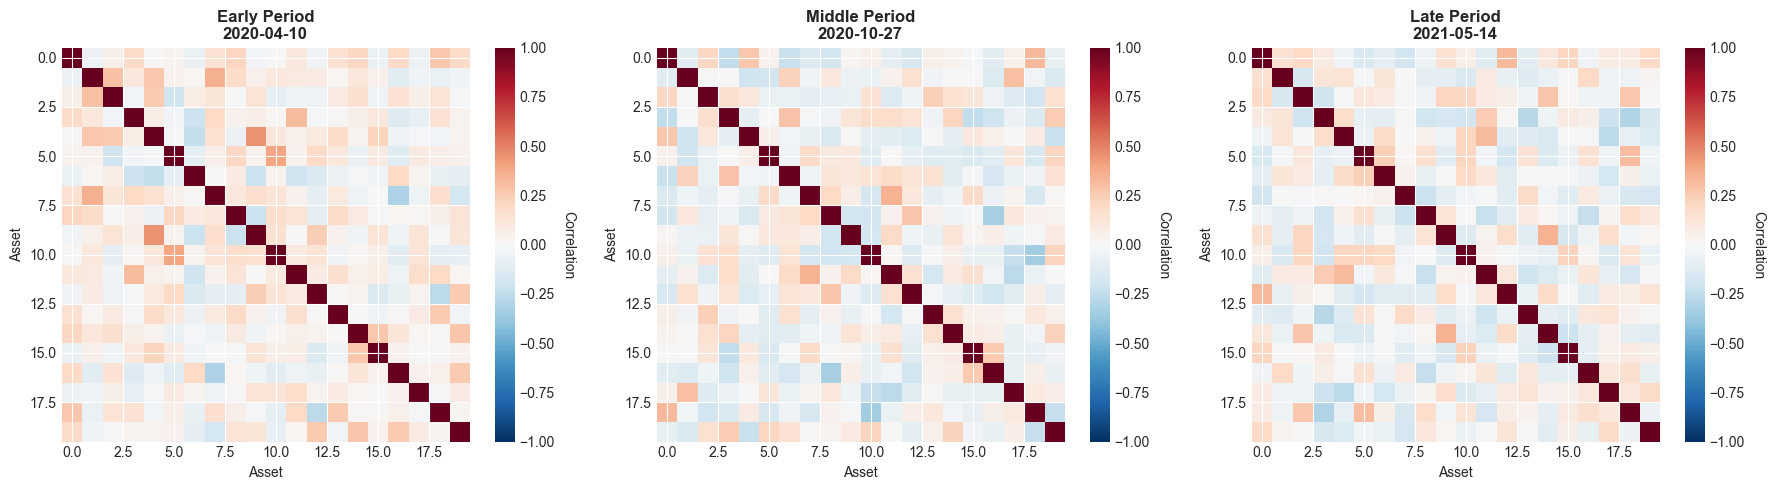

In [10]:
# Plot correlation matrices at different time points
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

time_points = [0, len(correlation_estimates)//2, -1]
titles = ['Early Period', 'Middle Period', 'Late Period']

for idx, (tp, title) in enumerate(zip(time_points, titles)):
    corr = correlation_estimates[tp]['correlation']
    date = correlation_estimates[tp]['date']
    
    im = axes[idx].imshow(corr, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')
    axes[idx].set_title(f'{title}\n{date.strftime("%Y-%m-%d")}', 
                       fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Asset')
    axes[idx].set_ylabel('Asset')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=axes[idx])
    cbar.set_label('Correlation', rotation=270, labelpad=15)

plt.tight_layout()
plt.show()

## 3. Apply Network Filtering Methods

In [11]:
# Select a sample correlation matrix
sample_idx = len(correlation_estimates) // 2
sample_corr = correlation_estimates[sample_idx]['correlation']
sample_date = correlation_estimates[sample_idx]['date']

print(f"Applying filters to correlation matrix from {sample_date.strftime('%Y-%m-%d')}")

# Convert to distance
distance_matrix = CorrelationFilter.correlation_to_distance(sample_corr)

# Apply filters
print("\nCreating filtered networks...")
mst = CorrelationFilter.minimum_spanning_tree(distance_matrix)
print(f"  MST: {mst.number_of_edges()} edges")

pmfg = CorrelationFilter.planar_maximally_filtered_graph(distance_matrix)
print(f"  PMFG: {pmfg.number_of_edges()} edges")

tmfg = CorrelationFilter.triangulated_maximally_filtered_graph(distance_matrix)
print(f"  TMFG: {tmfg.number_of_edges()} edges")

# Theoretical maximum
theoretical_max = 3 * (n_assets - 2)
complete_edges = n_assets * (n_assets - 1) // 2
print(f"\nTheoretical PMFG/TMFG edges: {theoretical_max}")
print(f"Complete graph edges: {complete_edges}")
print(f"PMFG retains: {pmfg.number_of_edges() / complete_edges * 100:.1f}% of edges")

Applying filters to correlation matrix from 2020-10-27

Creating filtered networks...
  MST: 19 edges
  PMFG: 54 edges
  TMFG: 54 edges

Theoretical PMFG/TMFG edges: 54
Complete graph edges: 190
PMFG retains: 28.4% of edges


### Visualize Filtered Networks

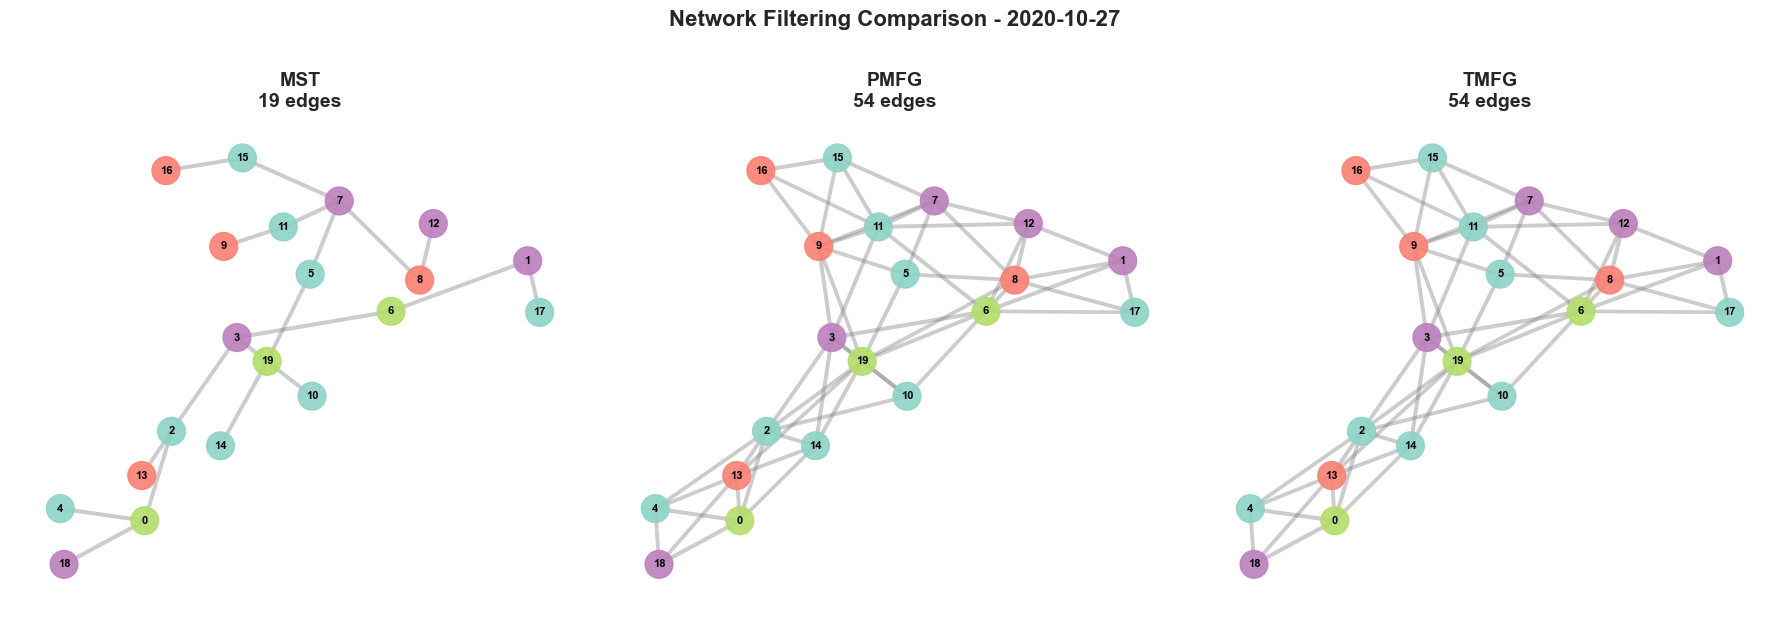

In [12]:
# Create side-by-side comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

graphs = {'MST': mst, 'PMFG': pmfg, 'TMFG': tmfg}

# Create stable layout using spring layout
pos = nx.spring_layout(pmfg, k=2/np.sqrt(n_assets), iterations=100, seed=42)

# Node colors (random clusters for visualization)
n_clusters = 4
cluster_assignments = np.random.choice(n_clusters, n_assets)
cmap = plt.cm.Set3
node_colors = [cmap(c / n_clusters) for c in cluster_assignments]

for idx, (method, G) in enumerate(graphs.items()):
    ax = axes[idx]
    
    # Draw edges
    edges = G.edges(data=True)
    if len(edges) > 0:
        weights = [1.0 / (1.0 + e[2].get('weight', 1.0)) for e in edges]
        max_weight = max(weights)
        edge_widths = [3 * w / max_weight for w in weights]
        
        nx.draw_networkx_edges(G, pos, width=edge_widths, 
                              alpha=0.4, edge_color='gray', ax=ax)
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_color=node_colors,
                          node_size=400, alpha=0.9, ax=ax)
    
    # Draw labels
    labels = {i: str(i) for i in range(n_assets)}
    nx.draw_networkx_labels(G, pos, labels, font_size=8, 
                           font_weight='bold', ax=ax)
    
    # Title
    ax.set_title(f'{method}\n{G.number_of_edges()} edges', 
                fontsize=14, fontweight='bold')
    ax.axis('off')

plt.suptitle(f'Network Filtering Comparison - {sample_date.strftime("%Y-%m-%d")}',
            fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### Network Statistics

In [13]:
def compute_network_stats(G, name):
    """Compute basic network statistics."""
    n_nodes = G.number_of_nodes()
    n_edges = G.number_of_edges()
    avg_degree = 2 * n_edges / n_nodes
    
    # Degree distribution
    degrees = [d for n, d in G.degree()]
    
    # Clustering coefficient
    avg_clustering = nx.average_clustering(G)
    
    # Connected components
    n_components = nx.number_connected_components(G)
    
    stats = {
        'Method': name,
        'Nodes': n_nodes,
        'Edges': n_edges,
        'Avg Degree': f'{avg_degree:.2f}',
        'Max Degree': max(degrees),
        'Min Degree': min(degrees),
        'Avg Clustering': f'{avg_clustering:.3f}',
        'Components': n_components
    }
    
    return stats

# Compute statistics for all methods
stats_list = []
for method, G in graphs.items():
    stats_list.append(compute_network_stats(G, method))

stats_df = pd.DataFrame(stats_list)
print("\nNetwork Statistics:")
print(stats_df.to_string(index=False))


Network Statistics:
Method  Nodes  Edges Avg Degree  Max Degree  Min Degree Avg Clustering  Components
   MST     20     19       1.90           4           1          0.000           1
  PMFG     20     54       5.40           9           3          0.655           1
  TMFG     20     54       5.40           9           3          0.655           1


### Degree Distribution

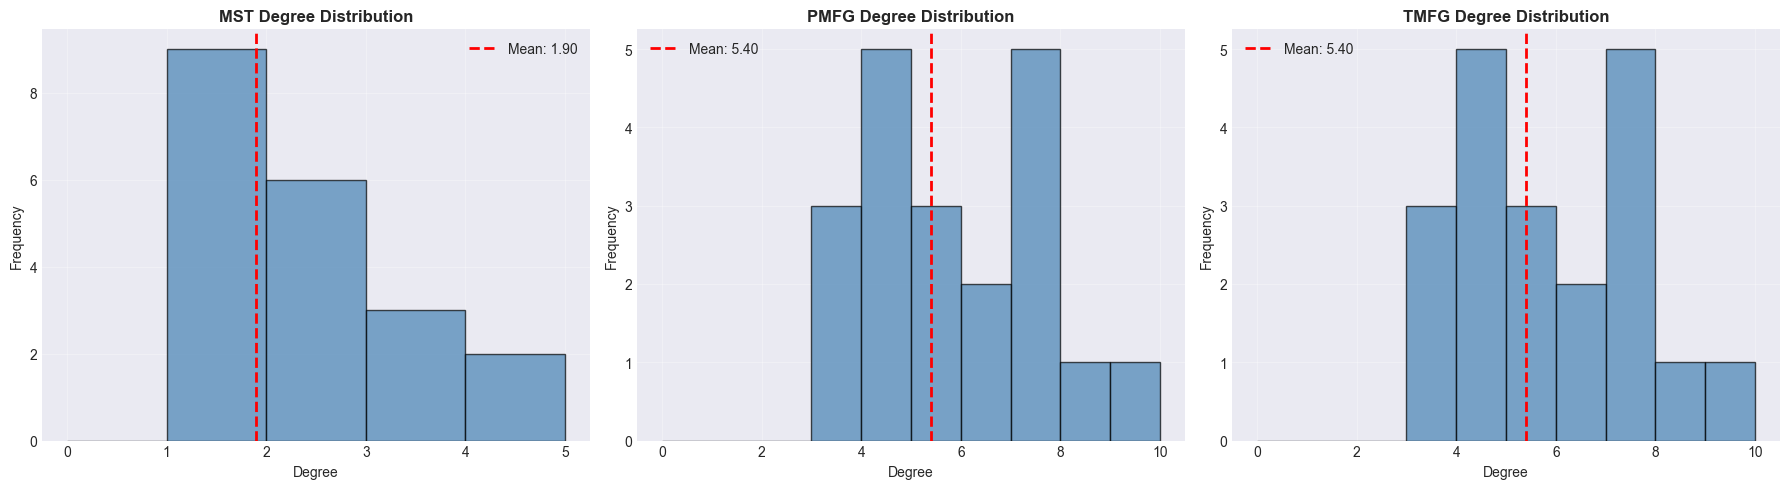

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (method, G) in enumerate(graphs.items()):
    degrees = [d for n, d in G.degree()]
    
    axes[idx].hist(degrees, bins=range(max(degrees)+2), alpha=0.7, 
                  color='steelblue', edgecolor='black')
    axes[idx].set_title(f'{method} Degree Distribution', 
                       fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Degree')
    axes[idx].set_ylabel('Frequency')
    axes[idx].grid(True, alpha=0.3)
    
    # Add mean line
    mean_degree = np.mean(degrees)
    axes[idx].axvline(mean_degree, color='red', linestyle='--', 
                     linewidth=2, label=f'Mean: {mean_degree:.2f}')
    axes[idx].legend()

plt.tight_layout()
plt.show()

## 4. Analyze Network Evolution Over Time

In [15]:
print("Computing network metrics over time...")

# Track metrics over time
metrics_over_time = []

for est in correlation_estimates[::10]:  # Sample every 10th for speed
    corr = est['correlation']
    dist = CorrelationFilter.correlation_to_distance(corr)
    
    mst_temp = CorrelationFilter.minimum_spanning_tree(dist)
    pmfg_temp = CorrelationFilter.planar_maximally_filtered_graph(dist)
    
    # Compute total weight (sum of distances = inverse of correlations)
    mst_weight = sum(d['weight'] for _, _, d in mst_temp.edges(data=True))
    pmfg_weight = sum(d['weight'] for _, _, d in pmfg_temp.edges(data=True))
    
    # Compute average clustering
    mst_clustering = nx.average_clustering(mst_temp)
    pmfg_clustering = nx.average_clustering(pmfg_temp)
    
    metrics_over_time.append({
        'date': est['date'],
        'mst_total_weight': mst_weight,
        'pmfg_total_weight': pmfg_weight,
        'mst_clustering': mst_clustering,
        'pmfg_clustering': pmfg_clustering,
        'avg_correlation': np.mean(corr[np.triu_indices_from(corr, k=1)])
    })

metrics_df = pd.DataFrame(metrics_over_time)
print(f"Computed metrics for {len(metrics_df)} time points")

Computing network metrics over time...
Computed metrics for 40 time points


### Visualize Network Metrics Over Time

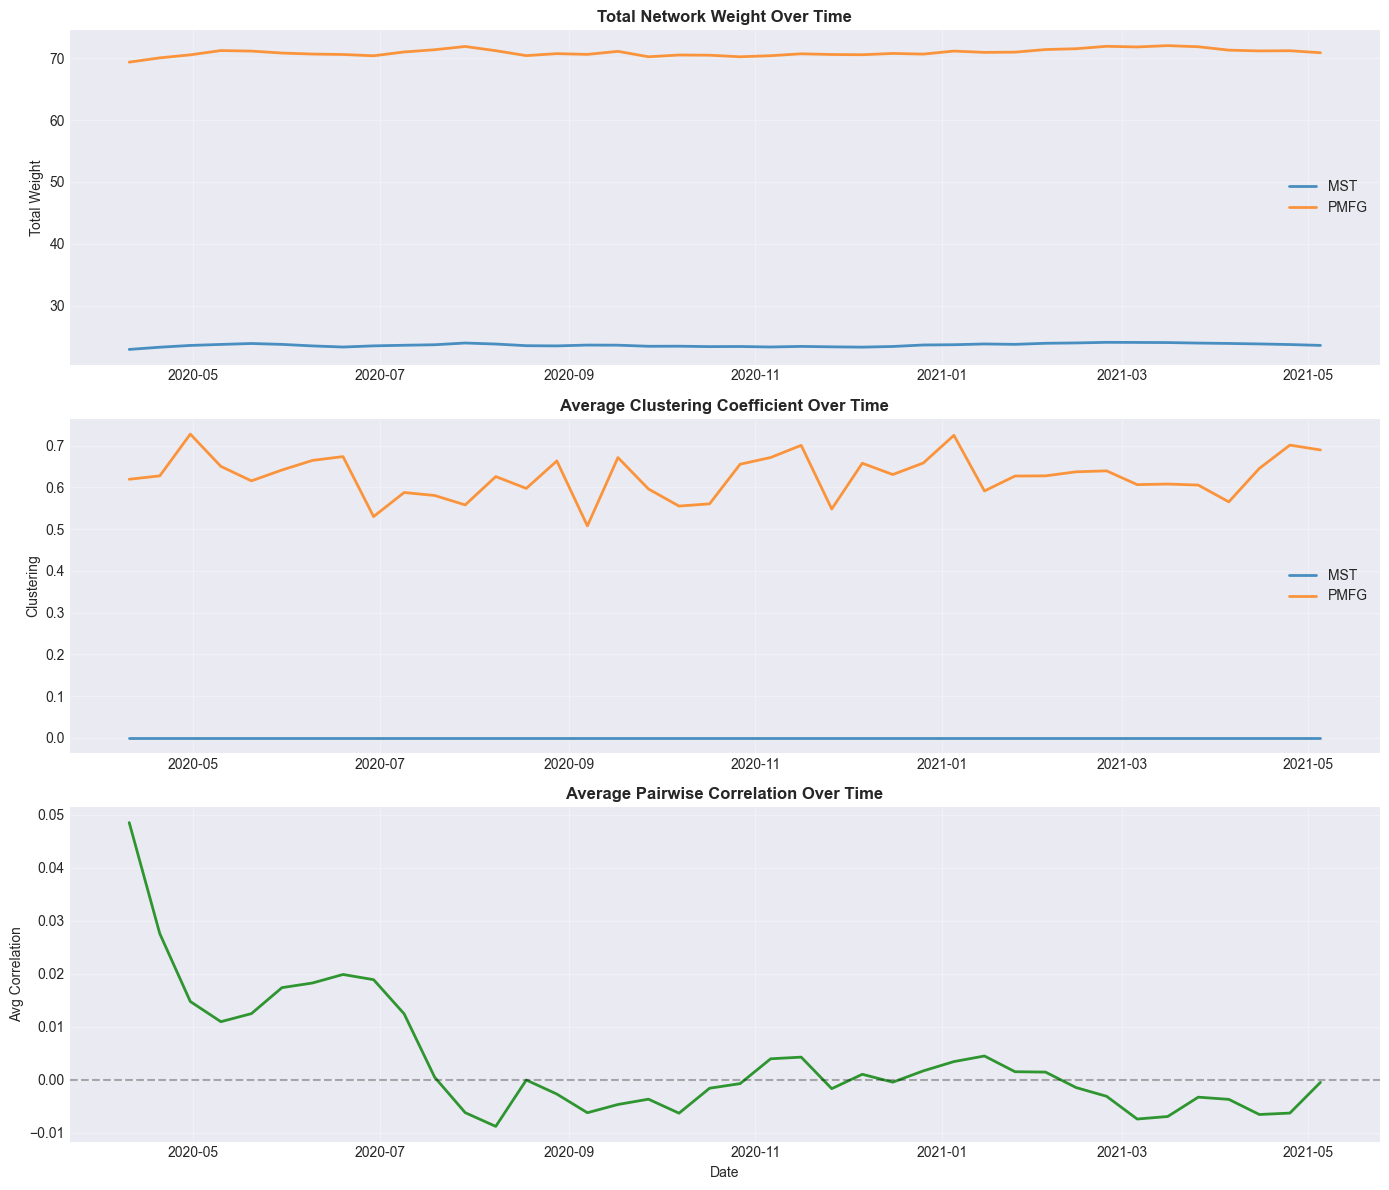

In [16]:
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# Plot 1: Total weight (inverse of correlation strength)
axes[0].plot(metrics_df['date'], metrics_df['mst_total_weight'], 
            label='MST', linewidth=2, alpha=0.8)
axes[0].plot(metrics_df['date'], metrics_df['pmfg_total_weight'], 
            label='PMFG', linewidth=2, alpha=0.8)
axes[0].set_title('Total Network Weight Over Time', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Total Weight')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Clustering coefficient
axes[1].plot(metrics_df['date'], metrics_df['mst_clustering'], 
            label='MST', linewidth=2, alpha=0.8)
axes[1].plot(metrics_df['date'], metrics_df['pmfg_clustering'], 
            label='PMFG', linewidth=2, alpha=0.8)
axes[1].set_title('Average Clustering Coefficient Over Time', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Clustering')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: Average correlation
axes[2].plot(metrics_df['date'], metrics_df['avg_correlation'], 
            linewidth=2, alpha=0.8, color='green')
axes[2].set_title('Average Pairwise Correlation Over Time', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Avg Correlation')
axes[2].grid(True, alpha=0.3)
axes[2].axhline(y=0, color='k', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Create Animations - NEW: Dynamic Layout Feature! 🎬

Now we'll create animated visualizations with both **dynamic** and **static** layouts.

### What's the Difference?

- **Dynamic Layout (NEW!)**: Nodes move according to force-directed layout based on evolving correlations
  - More engaging and intuitive
  - Shows how network structure changes
  - Perfect for presentations

- **Static Layout**: Nodes stay in fixed positions, only edges change
  - Easier to track individual nodes
  - Better for technical analysis

In [17]:
print("Creating network animations...")
print("This may take a few minutes depending on the number of frames.")
print("\nNote: You need ffmpeg installed to create video files.")
print("\n" + "="*70)
print("We'll create both DYNAMIC and STATIC layout versions for comparison")
print("="*70)

Creating network animations...
This may take a few minutes depending on the number of frames.

Note: You need ffmpeg installed to create video files.

We'll create both DYNAMIC and STATIC layout versions for comparison


### 5.1 Create DYNAMIC Layout Animation (NEW!)

In this mode, nodes move with force-directed layout as correlations evolve.

In [18]:
# Create animator with DYNAMIC layout
animator_dynamic = NetworkAnimator(figsize=(12, 10), dynamic_layout=True)

print("\n🎬 Creating DYNAMIC layout animation...")
print("   Nodes will move according to correlation structure!\n")

# Create PMFG animation with dynamic layout
try:
    animator_dynamic.animate_filtered_networks(
        correlation_estimates,
        filter_method='pmfg',
        output_file='pmfg_network_dynamic.mp4',
        fps=10,
        interval=100,
        smoothing_factor=0.3,  # Control movement smoothness (0=jittery, 1=static)
        k_factor=2.0  # Control node spacing (higher = more spread out)
    )
    print("\n✓ DYNAMIC layout animation created: pmfg_network_dynamic.mp4")
    print("  Watch nodes cluster and disperse as correlations change!")
except Exception as e:
    print(f"✗ Error creating animation: {e}")
    print("Make sure ffmpeg is installed.")


🎬 Creating DYNAMIC layout animation...
   Nodes will move according to correlation structure!

Creating filtered graphs using PMFG...
  Processing 1/400
  Processing 21/400
  Processing 41/400
  Processing 61/400
  Processing 81/400
  Processing 101/400
  Processing 121/400
  Processing 141/400
  Processing 161/400
  Processing 181/400
  Processing 201/400
  Processing 221/400
  Processing 241/400
  Processing 261/400
  Processing 281/400
  Processing 301/400
  Processing 321/400
  Processing 341/400
  Processing 361/400
  Processing 381/400
Computing dynamic force-directed layouts...
Computing dynamic layouts with smoothing=0.3...
  Computing layout 20/400
  Computing layout 40/400
  Computing layout 60/400
  Computing layout 80/400
  Computing layout 100/400
  Computing layout 120/400
  Computing layout 140/400
  Computing layout 160/400
  Computing layout 180/400
  Computing layout 200/400
  Computing layout 220/400
  Computing layout 240/400
  Computing layout 260/400
  Computing 

### 5.2 Create STATIC Layout Animation (Original Behavior)

In this mode, nodes stay in fixed positions throughout the animation.

In [19]:
# Create animator with STATIC layout
animator_static = NetworkAnimator(figsize=(12, 10), dynamic_layout=False)

print("\n📍 Creating STATIC layout animation...")
print("   Nodes will stay in fixed positions.\n")

# Create PMFG animation with static layout
try:
    animator_static.animate_filtered_networks(
        correlation_estimates,
        filter_method='pmfg',
        output_file='pmfg_network_static.mp4',
        fps=10,
        interval=100
    )
    print("\n✓ STATIC layout animation created: pmfg_network_static.mp4")
    print("  Easy to track individual nodes over time!")
except Exception as e:
    print(f"✗ Error creating animation: {e}")
    print("Make sure ffmpeg is installed.")


📍 Creating STATIC layout animation...
   Nodes will stay in fixed positions.

Creating filtered graphs using PMFG...
  Processing 1/400
  Processing 21/400
  Processing 41/400
  Processing 61/400
  Processing 81/400
  Processing 101/400
  Processing 121/400
  Processing 141/400
  Processing 161/400
  Processing 181/400
  Processing 201/400
  Processing 221/400
  Processing 241/400
  Processing 261/400
  Processing 281/400
  Processing 301/400
  Processing 321/400
  Processing 341/400
  Processing 361/400
  Processing 381/400
Computing static layout...
Creating animation...
Saving animation to pmfg_network_static.mp4...
Animation saved successfully!

✓ STATIC layout animation created: pmfg_network_static.mp4
  Easy to track individual nodes over time!


### 5.3 Experiment with Different Smoothing Parameters

The `smoothing_factor` parameter controls how smoothly nodes transition:
- Lower values (0.1-0.2): More responsive, nodes move quickly
- Medium values (0.3-0.5): Balanced movement
- Higher values (0.6-0.8): Very smooth, gradual changes

In [20]:
# Demonstrate different smoothing factors
print("\n🔧 Creating animations with different smoothing factors...\n")

smoothing_values = [
    (0.1, 'Very Responsive', 'lots of movement'),
    (0.5, 'Smooth', 'gradual changes'),
]

animator_demo = NetworkAnimator(figsize=(12, 10), dynamic_layout=True)

for smoothing, name, description in smoothing_values:
    print(f"Creating {name} animation (smoothing={smoothing})...")
    print(f"  Expected behavior: {description}")
    
    try:
        animator_demo.animate_filtered_networks(
            correlation_estimates,
            filter_method='pmfg',
            output_file=f'pmfg_smoothing_{smoothing}.mp4',
            fps=10,
            interval=100,
            smoothing_factor=smoothing
        )
        print(f"  ✓ Created: pmfg_smoothing_{smoothing}.mp4\n")
    except Exception as e:
        print(f"  ✗ Error: {e}\n")


🔧 Creating animations with different smoothing factors...

Creating Very Responsive animation (smoothing=0.1)...
  Expected behavior: lots of movement
Creating filtered graphs using PMFG...
  Processing 1/400
  Processing 21/400
  Processing 41/400
  Processing 61/400
  Processing 81/400
  Processing 101/400
  Processing 121/400
  Processing 141/400
  Processing 161/400
  Processing 181/400
  Processing 201/400
  Processing 221/400
  Processing 241/400
  Processing 261/400
  Processing 281/400
  Processing 301/400
  Processing 321/400
  Processing 341/400
  Processing 361/400
  Processing 381/400
Computing dynamic force-directed layouts...
Computing dynamic layouts with smoothing=0.1...
  Computing layout 20/400
  Computing layout 40/400
  Computing layout 60/400
  Computing layout 80/400
  Computing layout 100/400
  Computing layout 120/400
  Computing layout 140/400
  Computing layout 160/400
  Computing layout 180/400
  Computing layout 200/400
  Computing layout 220/400
  Computin

### 5.4 Create Comparison Animation (All Three Methods)

Compare MST, PMFG, and TMFG side-by-side with dynamic layout.

In [21]:
print("\n🔍 Creating comparison animation with DYNAMIC layout...\n")

# Create side-by-side comparison with dynamic layout
try:
    animator_dynamic.create_comparison_animation(
        correlation_estimates,
        output_file='network_comparison_dynamic.mp4',
        fps=10,
        smoothing_factor=0.3
    )
    print("✓ Dynamic comparison animation created: network_comparison_dynamic.mp4")
    print("  All three methods (MST, PMFG, TMFG) with dynamic layouts!")
except Exception as e:
    print(f"✗ Error creating animation: {e}")
    print("Make sure ffmpeg is installed.")


🔍 Creating comparison animation with DYNAMIC layout...

Creating filtered graphs for all methods...
  Processing 1/400
  Processing 21/400
  Processing 41/400
  Processing 61/400
  Processing 81/400
  Processing 101/400
  Processing 121/400
  Processing 141/400
  Processing 161/400
  Processing 181/400
  Processing 201/400
  Processing 221/400
  Processing 241/400
  Processing 261/400
  Processing 281/400
  Processing 301/400
  Processing 321/400
  Processing 341/400
  Processing 361/400
  Processing 381/400
Computing layouts for each method...
  Computing dynamic layouts for MST...
Computing dynamic layouts with smoothing=0.3...
  Computing layout 20/400
  Computing layout 40/400
  Computing layout 60/400
  Computing layout 80/400
  Computing layout 100/400
  Computing layout 120/400
  Computing layout 140/400
  Computing layout 160/400
  Computing layout 180/400
  Computing layout 200/400
  Computing layout 220/400
  Computing layout 240/400
  Computing layout 260/400
  Computing la

### Animation Summary

You should now have several animation files:

**Dynamic Layout Animations:**
- `pmfg_network_dynamic.mp4` - PMFG with moving nodes
- `pmfg_smoothing_0.1.mp4` - Very responsive movement
- `pmfg_smoothing_0.5.mp4` - Smooth, gradual movement
- `network_comparison_dynamic.mp4` - All three methods with dynamic layout

**Static Layout Animation:**
- `pmfg_network_static.mp4` - PMFG with fixed node positions

**Compare them to see the difference!**

### Tips for Using Dynamic Layout:

1. **For presentations**: Use `smoothing_factor=0.3` (balanced)
2. **For dramatic effect**: Use `smoothing_factor=0.1` (very responsive)
3. **For smooth videos**: Use `smoothing_factor=0.5` (gradual changes)
4. **For node tracking**: Use static layout instead
5. **For large networks**: Consider static layout (faster computation)

## 6. Export Network Data

Save network metrics and filtered networks for further analysis.

In [22]:
# Save network metrics
metrics_df.to_csv('network_metrics_over_time.csv', index=False)
print("✓ Network metrics saved to 'network_metrics_over_time.csv'")

# Save returns data
returns_df.to_csv('synthetic_returns.csv')
print("✓ Returns data saved to 'synthetic_returns.csv'")

✓ Network metrics saved to 'network_metrics_over_time.csv'
✓ Returns data saved to 'synthetic_returns.csv'


## Summary

This notebook demonstrated:

1. **Synthetic data generation** with time-varying correlations
2. **Rolling correlation estimation** using moving windows
3. **Network filtering methods**: MST, PMFG, and TMFG
4. **Static visualization** of filtered networks
5. **Network metrics** and their evolution over time
6. **Animation creation** with both **dynamic** and **static** layouts

### Key Findings

**Filtering Methods:**
- **MST**: Most sparse (N-1 edges), captures hierarchical structure
- **PMFG**: Medium density (3(N-2) edges), balances information and sparsity
- **TMFG**: Similar to PMFG but faster computation

**Layout Modes:**
- **Dynamic Layout (NEW!)**: Nodes move with correlation changes
  - More engaging and intuitive
  - Shows network structure evolution
  - Perfect for presentations and teaching
  
- **Static Layout**: Nodes stay fixed
  - Easier to track individual nodes
  - Better for detailed analysis
  - Faster computation

### Dynamic Layout Parameters

**`smoothing_factor`** (0.0 to 1.0):
- 0.1 = Very responsive, lots of movement
- 0.3 = Balanced (recommended for most uses)
- 0.5 = Smooth, gradual changes
- 0.8 = Very smooth, minimal movement

**`k_factor`** (1.0 to 3.0):
- 1.5 = Compact layout
- 2.0 = Balanced spacing (recommended)
- 3.0 = Spread out layout

### Next Steps

- Apply to real market data
- Compare dynamic vs static animations for your use case
- Experiment with different smoothing parameters
- Investigate correlation structure changes during crisis periods
- Analyze community detection and sector identification
- Explore relationship between network structure and portfolio performance

### Resources

For more information on dynamic layouts:
- Read `DYNAMIC_LAYOUT_GUIDE.md` for comprehensive documentation
- Run `example_dynamic_layout.py` for a standalone demonstration
- Check `UPDATE_SUMMARY.md` for a quick overview of the feature